# Figure 5: Condensates Analyses

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from matplotlib import pyplot as plt
from scipy import stats
from statannotations.Annotator import Annotator

sys.path.append("../")

from plotting import violinplot_reflected, mimic_r_boxplot
from data_loading import load_ref_vs_alt_isoforms_table

PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2023)

## functions

In [4]:
# def permutation_test(x, y):
#     """
#     two-sided
#     """
#     nx = x.shape[0]
#     ny = y.shape[0]
#     obs = x.mean() - y.mean()
#     merged = np.concatenate([x, y])
#     rnd = []
#     for _i in range(100000):
#         np.random.shuffle(merged)
#         rnd.append(merged[:nx].mean() - merged[nx:].mean())
#     return (min([sum(r >= obs for r in rnd), sum(r <= obs for r in rnd)]) / len(rnd)) * 2

In [5]:
def permutation_test(sample1, sample2, num_permutations=1000, seed=None, alternative='two-sided'):
    """
    Conduct a permutation test on two samples.

    :param sample1: First sample (array-like)
    :param sample2: Second sample (array-like)
    :param num_permutations: Number of permutations to perform (int)
    :param seed: Seed for random number generator (int)
    :param alternative: Defines the alternative hypothesis. 
                        'two-sided': the distributions are not equal,
                        'less': the distribution of sample1 is less than the distribution of sample2,
                        'greater': the distribution of sample1 is greater than the distribution of sample2
    :return: p-value (float)
    """

    # Ensure reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Combine the samples
    combined = np.concatenate([sample1, sample2])

    # Calculate the observed test statistic
    observed_stat = np.mean(sample1) - np.mean(sample2)

    # Perform the permutations
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_sample_1 = combined[:len(sample1)]
        new_sample_2 = combined[len(sample1):]

        # Calculate the new test statistic
        new_stat = np.mean(new_sample_1) - np.mean(new_sample_2)

        # Check if the new test statistic is at least as extreme as the original
        if alternative == 'two-sided':
            count += abs(new_stat) >= abs(observed_stat)
        elif alternative == 'less':
            count += new_stat <= observed_stat
        elif alternative == 'greater':
            count += new_stat >= observed_stat
        else:
            raise ValueError("alternative must be 'two-sided', 'less', or 'greater'")

    # Calculate the p-value
    p_value = (count + 1) / (num_permutations + 1)

    return p_value

## 1. import data

In [6]:
df = pd.read_excel('../../data/internal/TFiso_LLPS_scores_HEK_20230909_V6.xlsx')
df['gene_symbol'] = df['isoform_acc'].map(lambda x: x.split('|')[0])
df['condensates_observed'] = df['Cond_Score'].map({1: True, 0: False})
df['is_cloned_reference'] = df['Ref_isoform'].map({'Reference': True,
                                                   'Alternative': False})
df['HEK_Condensate'] = df['HEK_Condensate'].str.upper().str.strip()
df['HEK_Condensate'] = df['HEK_Condensate'].map(lambda x: {'BOTH(MOST NC)': 'BOTH'}.get(x, x))
if df['isoform_acc'].duplicated().any():
    raise UserWarning('unexpected duplicates')

In [7]:
df['Mutation_Class'].value_counts()

Unchanged               73
Ref                     60
GOC                     21
LOC                     21
Changed localization    14
Name: Mutation_Class, dtype: int64

In [8]:
df['Loc_Kaia'].value_counts()

both    111
nuc      46
cyto     18
Name: Loc_Kaia, dtype: int64

## 2. summary of data

In [9]:
print('tested {} isoforms of {} TF genes'.format(df['isoform_acc'].nunique(),
                df['gene_symbol'].nunique())
)
print('{} ({:.0%}) reference isoforms show condensates'.format(
    df.loc[df['is_cloned_reference'], 'condensates_observed'].sum(),
    df.loc[df['is_cloned_reference'], 'condensates_observed'].mean()))
print('{} ({:.0%}) alternative isoforms show condensates'.format(
    df.loc[~df['is_cloned_reference'], 'condensates_observed'].sum(),
    df.loc[~df['is_cloned_reference'], 'condensates_observed'].mean()))
print('{} ({:.0%}) alternative isoforms change condensate formation compared to reference'.format(
    (df.loc[~df['is_cloned_reference'], 'Mutation_Class'] != 'Unchanged').sum(),
    (df.loc[~df['is_cloned_reference'], 'Mutation_Class'] != 'Unchanged').mean()))

print()
print(df.loc[~df['is_cloned_reference'], 'Mutation_Class'].value_counts())
print()



tested 189 isoforms of 60 TF genes
41 (68%) reference isoforms show condensates
93 (72%) alternative isoforms show condensates
56 (43%) alternative isoforms change condensate formation compared to reference

Unchanged               73
LOC                     21
GOC                     21
Changed localization    14
Name: Mutation_Class, dtype: int64



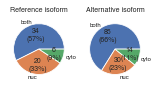

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2.5, 2.5))
n = df['is_cloned_reference'].sum()
(
    df.loc[df['is_cloned_reference'], 'Loc_Kaia']
    .value_counts()
    .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
 ax=axs[0])
)
n = (~df['is_cloned_reference']).sum()
(
    df.loc[~df['is_cloned_reference'], 'Loc_Kaia']
    .value_counts()
    .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
 ax=axs[1])
)
axs[0].set_title('Reference isoform')
axs[1].set_title('Alternative isoform')
for ax in axs:
    ax.set_ylabel('')
fig.savefig('../../figures/fig5/kaia-localisation_ref-vs-alt_pie.pdf',
            bbox_inches='tight')

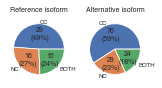

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2.5, 2.5))
n = df['is_cloned_reference'].sum()
(
    df.loc[df['is_cloned_reference'], 'HEK_Condensate']
    .value_counts()
    .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
 ax=axs[0])
)
n = (~df['is_cloned_reference']).sum()
(
    df.loc[~df['is_cloned_reference'], 'HEK_Condensate']
    .value_counts()
    .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
 ax=axs[1])
)
axs[0].set_title('Reference isoform')
axs[1].set_title('Alternative isoform')
for ax in axs:
    ax.set_ylabel('')
fig.savefig('../../figures/fig5/condensate-localisation_ref-vs-alt_pie.pdf',
            bbox_inches='tight')

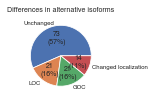

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.4))
n = (~df['is_cloned_reference']).sum()
(df.loc[~df['is_cloned_reference'], 'Mutation_Class']
 .value_counts()
 .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
 ax=ax))
ax.set_ylabel('')
ax.set_title('Differences in alternative isoforms')
fig.savefig('../../figures/fig5/condensate-change-categories_pie.pdf',
            bbox_inches='tight')

In [13]:
print('all:')
print(df['HEK_Condensate'].value_counts())
print('\nreference:')
print(df.loc[df['is_cloned_reference'], 'HEK_Condensate'].value_counts())
print('\nalternative')
print(df.loc[~df['is_cloned_reference'], 'HEK_Condensate'].value_counts())

all:
CC      75
NC      32
BOTH    27
Name: HEK_Condensate, dtype: int64

reference:
CC      20
NC      11
BOTH    10
Name: HEK_Condensate, dtype: int64

alternative
CC      55
NC      21
BOTH    17
Name: HEK_Condensate, dtype: int64


## 3. merge info with pairs data to see how condensates correlate w PPIs/PDIs/etc

In [14]:
pairs = load_ref_vs_alt_isoforms_table()
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,...,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,...,9.0,11.0,11.0,9.0,9.0,0.818182,True,1.552087,0.773129,-0.778958
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389


In [15]:
df = df.set_index('isoform_acc')

In [16]:
for x in ['ref', 'alt']:
    for var in ['condensates_observed', 'HEK_Condensate', 'Loc_Kaia']:
        pairs[var + '_' + x] = pairs['clone_acc_' + x].map(df[var])

In [17]:
pairs['condensate_cat'] = pairs['clone_acc_alt'].map(df['Mutation_Class'])

In [18]:
pairs = pairs.loc[pairs['condensates_observed_ref'].notnull(), :]

In [19]:
pairs['condensate_cat'].value_counts()

Unchanged               73
LOC                     21
GOC                     21
Changed localization    14
Name: condensate_cat, dtype: int64

In [20]:
pairs['Loc_Kaia_ref'].value_counts()

both    72
nuc     43
cyto    10
Name: Loc_Kaia_ref, dtype: int64

In [21]:
pairs['condensate_cat_merged'] = pairs['condensate_cat'].map({
    'Unchanged': 'No difference',
    'LOC': 'Difference',
    'GOC': 'Difference',
    'Changed localization': 'Difference',
    })

In [22]:
pairs.loc[(pairs['n_positive_PPI_ref'] == 0) | (pairs['n_positive_PPI_alt'] == 0),
          'PPI_jaccard'] = np.nan

0.0476952304769523
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.048


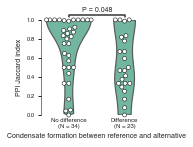

In [23]:
var = 'PPI_jaccard'
x = pairs.loc[(pairs['condensate_cat'] == 'Unchanged')
              & pairs[var].notnull(), 
              var].values
y = pairs.loc[(pairs['condensate_cat'] != 'Unchanged')
              & pairs[var].notnull(), 
              var].values

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=1.75)
sns.swarmplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              order=['No difference', 'Difference'],
              color='white',
              ax=ax,
              edgecolor="black",
              linewidth=0.5,
              clip_on=False,
              size=4)
violinplot_reflected(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
                    inner=None,
              #cut=0,
              color=sns.color_palette("Set2")[0],
              order=['No difference', 'Difference'],
              ax=ax,
              )
ax.set_ylim(0, 1)

pval = permutation_test(x, y, num_permutations=10000, seed=2023)
print(pval)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], 
                      data=pairs, x='condensate_cat_merged', 
                      y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.3f}'.format(pval)])

ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('PPI Jaccard index')
ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../../figures/fig5/PPI-Jaccard-vs-condensate-change_violinplot.pdf',
            bbox_inches='tight')

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0.11578842115788421
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.116


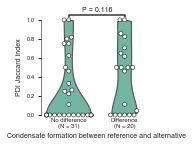

In [24]:
var = 'PDI_jaccard'
x = pairs.loc[(pairs['condensate_cat'] == 'Unchanged')
              & pairs[var].notnull(), 
              var].values
y = pairs.loc[(pairs['condensate_cat'] != 'Unchanged')
              & pairs[var].notnull(), 
              var].values

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=1.75)
sns.swarmplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              order=['No difference', 'Difference'],
              color='white',
              edgecolor='black',
              linewidth=0.5,
              ax=ax,
              clip_on=False,
              size=4)
violinplot_reflected(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
                    inner=None,
              #cut=0,
              color=sns.color_palette("Set2")[0],
              order=['No difference', 'Difference'],
              ax=ax,
              )
ax.set_ylim(0, 1)

pval = permutation_test(x, y, num_permutations=10000, seed=2023)
print(pval)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.3f}'.format(pval)])

ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('PDI Jaccard index')
ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../../figures/fig5/PDI-Jaccard-vs-condensate-change_violinplot.pdf',
            bbox_inches='tight')

0.039196080391960805
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.039


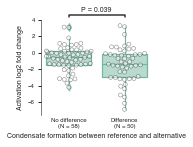

In [25]:
var = 'activation_fold_change_log2'
x = pairs.loc[(pairs['condensate_cat'] == 'Unchanged')
              & pairs[var].notnull(), 
              var].values
y = pairs.loc[(pairs['condensate_cat'] != 'Unchanged')
              & pairs[var].notnull(), 
              var].values

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=1.75)
sns.swarmplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              order=['No difference', 'Difference'],
              color='white',
              edgecolor='black',
              alpha=0.5,
              linewidth=0.5,
              ax=ax,
              clip_on=False,
              size=4)
sns.boxplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              #cut=0,
              color=sns.color_palette("Set2")[0],
              order=['No difference', 'Difference'],
              ax=ax,
              )
mimic_r_boxplot(ax)

pval = permutation_test(x, y, num_permutations=10000, seed=2023)
print(pval)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.3f}'.format(pval)])

ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../../figures/fig5/activation-vs-condensate-change_boxplot.pdf',
            bbox_inches='tight')

## 4. look in more granularity (cytoplasmic v nuclear, etc)

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


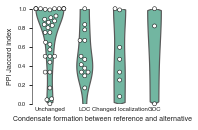

In [26]:
var = 'PPI_jaccard'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.75)
sns.swarmplot(data=pairs,
                     x='condensate_cat',
                     y=var,
              color='white',
              edgecolor='black',
              linewidth=0.5,
              ax=ax,
              clip_on=False,
              size=4)
violinplot_reflected(data=pairs,
                     x='condensate_cat',
                     y=var,
                    inner=None,
              color=sns.color_palette("Set2")[0],
              ax=ax,
              )
ax.set_ylim(0, 1)

"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""

ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('PPI Jaccard index')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../../figures/fig5/PPI-Jaccard-vs-condensate-change_categories_boxplot.pdf',
            bbox_inches='tight')

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


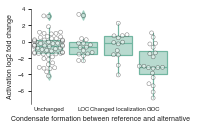

In [27]:
var = 'activation_fold_change_log2'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=1.75)
sns.swarmplot(data=pairs,
                     x='condensate_cat',
                     y=var,
              color='white',
              edgecolor='black',
              alpha=0.5,
              linewidth=0.5,
              ax=ax,
              clip_on=False,
              size=4)
sns.boxplot(data=pairs,
                     x='condensate_cat',
                     y=var,
              color=sns.color_palette("Set2")[0],
              ax=ax,
              )
mimic_r_boxplot(ax)

"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../../figures/fig5/activation-vs-condensate-change_categories_boxplot.pdf',
            bbox_inches='tight')

In [28]:
def detailed_condensate_cat(row):
    a = row['HEK_Condensate_ref']
    if pd.isnull(a):
        a = 'None'
    b = row['HEK_Condensate_alt']
    if pd.isnull(b):
        b = 'None'
    return '{} -> {}'.format(a, b)

pairs['condensate_cat_detailed'] = pairs.apply(detailed_condensate_cat, axis=1)

In [29]:
pairs.sort_values('activation_fold_change_log2').head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,activation_fold_change_log2,condensates_observed_ref,HEK_Condensate_ref,Loc_Kaia_ref,condensates_observed_alt,HEK_Condensate_alt,Loc_Kaia_alt,condensate_cat,condensate_cat_merged,condensate_cat_detailed
114,TBPL1,ENSG00000028839,TBP,False,TBPL1|1/2|04H06,TBPL1|2/2|04A07,ENST00000237264|ENST00000613034,ENST00000367871,False,False,...,-6.864281,False,NaN,both,True,CC,both,GOC,Difference,None -> CC
163,TFEC,ENSG00000105967,bHLH,True,TFEC|1/6|03F07,TFEC|3/6|03C11,ENST00000265440,ENST00000484212,False,False,...,-6.132327,False,NaN,both,True,CC,both,GOC,Difference,None -> CC
240,FOXJ2,ENSG00000065970,Forkhead,False,FOXJ2|1/2|06F10,FOXJ2|2/2|06B11,ENST00000162391,ENST00000428177,False,False,...,-5.383136,False,NaN,nuc,True,CC,both,GOC,Difference,None -> CC
166,TFEC,ENSG00000105967,bHLH,True,TFEC|1/6|03F07,TFEC|6/6|03E11,ENST00000265440,NaN,False,True,...,-5.128960,False,NaN,both,True,CC,both,GOC,Difference,None -> CC
222,CREBZF,ENSG00000137504,bZIP,True,CREBZF|1/2|04B03,CREBZF|2/2|04C04,ENST00000527447,ENST00000534224,False,False,...,-4.377453,False,NaN,NaN,True,CC,NaN,GOC,Difference,None -> CC


In [30]:
pairs.sort_values('activation_fold_change_log2', ascending=False).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,activation_fold_change_log2,condensates_observed_ref,HEK_Condensate_ref,Loc_Kaia_ref,condensates_observed_alt,HEK_Condensate_alt,Loc_Kaia_alt,condensate_cat,condensate_cat_merged,condensate_cat_detailed
50,ATF2,ENSG00000115966,bZIP,True,ATF2|1/6|12H04,ATF2|5/6|09A05,ENST00000264110|ENST00000392544,ENST00000409833,False,False,...,3.306912,True,CC,both,False,NaN,both,LOC,Difference,CC -> None
368,ZNF473,ENSG00000142528,C2H2 ZF,False,ZNF473|1/2|10F12,ZNF473|2/2|01B08,ENST00000270617|ENST00000391821|ENST00000595661,ENST00000601364,False,False,...,3.170526,True,NC,nuc,False,NaN,both,LOC,Difference,NC -> None
40,DLX1,ENSG00000144355,Homeodomain,False,DLX1|1/2|07A12,DLX1|2/2|07E09,ENST00000361725,ENST00000341900,False,False,...,3.122124,False,NaN,NaN,False,NaN,NaN,Unchanged,No difference,None -> None
46,E2F6,ENSG00000169016,E2F,True,E2F6|1/2|10C02,E2F6|2/2|01A04,ENST00000381525,ENST00000542100|ENST00000546212,False,False,...,3.075493,True,CC,cyto,True,CC,cyto,Unchanged,No difference,CC -> CC
153,FOXP2,ENSG00000128573,Forkhead,False,FOXP2|2/10|07B01,FOXP2|10/10|06A10,ENST00000350908|ENST00000393494,ENST00000462331,False,False,...,2.235620,True,NC,nuc,True,CC,both,Changed localization,Difference,NC -> CC


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/p

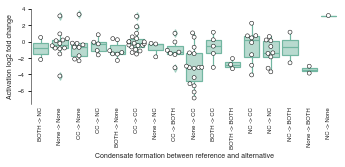

In [31]:
var = 'activation_fold_change_log2'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=5.5, h=1.75)
sns.swarmplot(data=pairs,
                     x='condensate_cat_detailed',
                     y=var,
              color='white',
              edgecolor='black',
              linewidth=0.5,
              ax=ax,
              clip_on=False,
              size=4)
sns.boxplot(data=pairs,
                     x='condensate_cat_detailed',
                     y=var,
              color=sns.color_palette("Set2")[0],
              ax=ax,
              )
mimic_r_boxplot(ax)

"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0, rotation=90)
fig.savefig('../../figures/fig4/activation-vs-condensate-change_categories-detailed_boxplot.pdf',
            bbox_inches='tight')

- CREB1 - the alternative isoform, with a small insertion, forms nuclear condensates (and doesn't bind DNA...)
- TBX5 - alternative isoforms form cytoplasmic condensates. TBX5-3, which doesn't activate, doesn't seem to be in the nucleus...
- ZIC3 - novel isoforms form condensates
- **PBX1** - ref forms condensates in both nucleus and cytoplasm. alt looses them

## 5. are any PPIs in our y2h data well-known LLPS drivers?

In [32]:
from data_loading import load_y2h_isoform_data
y2h = load_y2h_isoform_data()
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [33]:
llps_proteins = {'FUS', 'EWS', 'TAF15', 'DDX4',
                 'BRD4', 'MED1',
                 'TFEB',
                 'YAP',}
y2h.loc[y2h['db_gene_symbol'].isin(llps_proteins), :]

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result


In [34]:
# could also look for low complexity disordered regions

## 6. examine how expression correlates with condensate formation

In [35]:
from data_loading import (load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped)

In [36]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [37]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


In [38]:
means_gtex["max_gtex"] = means_gtex.max(axis=1)
max_gtex = means_gtex[["max_gtex"]] 

means_dev["max_dev"] = means_dev.max(axis=1)
max_dev = means_dev[["max_dev"]]

max_tpm = max_gtex.join(max_dev)
max_tpm = np.log2(max_tpm+1)
max_tpm = max_tpm.reset_index()
max_tpm["clone_acc"] = max_tpm.UID.str.split(" ", expand=True)[0]

In [39]:
max_tpm["gene_symbol"] = max_tpm["clone_acc"].str.split("|", expand=True)[0]
max_tpm_gene = max_tpm[["gene_symbol", "max_gtex", "max_dev"]]
max_tpm_gene = max_tpm_gene.groupby("gene_symbol")[["max_gtex", "max_dev"]].agg("sum").reset_index()
max_tpm_gene.columns = ["gene_symbol", "max_gtex_gene", "max_dev_gene"]

In [40]:
pairs = pairs.merge(max_tpm[["clone_acc", "max_gtex", 
                             "max_dev"]],
                    left_on="clone_acc_ref", right_on="clone_acc")
pairs.drop("clone_acc", axis=1, inplace=True)
pairs = pairs.merge(max_tpm[["clone_acc", "max_gtex", "max_dev"]],
                    left_on="clone_acc_alt", 
                    right_on="clone_acc",
                    suffixes=("_ref", "_alt"))
pairs.drop("clone_acc", axis=1, inplace=True)
pairs = pairs.merge(max_tpm_gene, on="gene_symbol")
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,Loc_Kaia_alt,condensate_cat,condensate_cat_merged,condensate_cat_detailed,max_gtex_ref,max_dev_ref,max_gtex_alt,max_dev_alt,max_gtex_gene,max_dev_gene
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,...,both,Unchanged,No difference,BOTH -> NC,3.119615,3.402279,2.996788,3.260954,6.116403,6.663233
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,...,NaN,Unchanged,No difference,None -> None,2.856889,2.835991,2.420840,2.290445,7.489377,7.683716
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,...,NaN,Unchanged,No difference,None -> None,2.856889,2.835991,2.211648,2.557280,7.489377,7.683716
3,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,...,nuc,LOC,Difference,CC -> None,2.902086,1.775482,1.261399,0.907528,7.919554,6.649063
4,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,...,nuc,LOC,Difference,CC -> None,2.902086,1.775482,0.544584,0.271218,7.919554,6.649063


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: P = 0.74


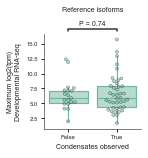

In [41]:
fig = plt.figure(figsize=(1.75, 1.75))

x_var = "condensates_observed_ref"
y_var = "max_dev_gene"
data = pairs[["clone_acc_ref", x_var, y_var]].drop_duplicates()
ax = sns.boxplot(data=data, x=x_var, y=y_var,
                 color=sns.color_palette("Set2")[0],
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=data, x=x_var, y=y_var, 
              edgecolor="black", linewidth=0.5, color=sns.color_palette("Set2")[0], ax=ax,
              size=3, alpha=0.5)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Condensates observed")
ax.set_ylabel("Maximum log2(tpm)\nDevelopmental RNA-seq")
ax.set_title("Reference isoforms\n\n")

x = data[data[x_var] == False][y_var].values
y = data[data[x_var] == True][y_var].values
pval = permutation_test(x, y, num_permutations=10000, seed=2023)
annotator = Annotator(ax=ax, pairs=[(False, True)], 
                      data=data, x='condensates_observed_ref', 
                      y='max_dev_gene', order=[False, True],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])

fig.savefig("../../figures/fig5/Dev_expr_cond.pdf", dpi="figure", bbox_inches="tight")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: P = 0.55


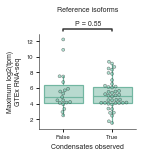

In [42]:
fig = plt.figure(figsize=(1.75, 1.75))

x_var = "condensates_observed_ref"
y_var = "max_gtex_gene"
data = pairs[["clone_acc_ref", x_var, y_var]].drop_duplicates()
ax = sns.boxplot(data=data, x=x_var, y=y_var,
                 color=sns.color_palette("Set2")[0],
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=data, x=x_var, y=y_var, 
              edgecolor="black", linewidth=0.5, color=sns.color_palette("Set2")[0], ax=ax,
              size=3, alpha=0.5)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Condensates observed")
ax.set_ylabel("Maximum log2(tpm)\nGTEx RNA-seq")
ax.set_title("Reference isoforms\n\n")

x = data[data[x_var] == False][y_var].values
y = data[data[x_var] == True][y_var].values
pval = permutation_test(x, y, num_permutations=10000, seed=2023)
annotator = Annotator(ax=ax, pairs=[(False, True)], 
                      data=data, x=x_var, 
                      y=y_var, order=[False, True],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])

fig.savefig("../../figures/fig5/GTEx_expr_cond.pdf", dpi="figure", bbox_inches="tight")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: P = 0.63


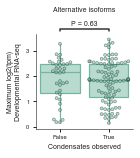

In [43]:
fig = plt.figure(figsize=(1.75, 1.75))

x_var = "condensates_observed_alt"
y_var = "max_dev_alt"
data = pairs[["clone_acc_alt", x_var, y_var]].drop_duplicates()
ax = sns.boxplot(data=data, x=x_var, y=y_var,
                 color=sns.color_palette("Set2")[0],
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=data, x=x_var, y=y_var, 
              edgecolor="black", linewidth=0.5, color=sns.color_palette("Set2")[0], ax=ax,
              size=3, alpha=0.5)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Condensates observed")
ax.set_ylabel("Maximum log2(tpm)\nDevelopmental RNA-seq")
ax.set_title("Alternative isoforms\n\n")

x = data[data[x_var] == False][y_var].values
y = data[data[x_var] == True][y_var].values
pval = permutation_test(x, y, num_permutations=10000, seed=2023)
annotator = Annotator(ax=ax, pairs=[(False, True)], 
                      data=data, x=x_var, 
                      y=y_var, order=[False, True],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])

fig.savefig("../../figures/fig5/Dev_expr_cond_alt.pdf", dpi="figure", bbox_inches="tight")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: P = 0.42


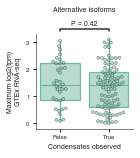

In [44]:
fig = plt.figure(figsize=(1.75, 1.75))

x_var = "condensates_observed_alt"
y_var = "max_gtex_alt"
data = pairs[["clone_acc_alt", x_var, y_var]].drop_duplicates()
ax = sns.boxplot(data=data, x=x_var, y=y_var,
                 color=sns.color_palette("Set2")[0],
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=data, x=x_var, y=y_var, 
              edgecolor="black", linewidth=0.5, color=sns.color_palette("Set2")[0], ax=ax,
              size=3, alpha=0.5)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Condensates observed")
ax.set_ylabel("Maximum log2(tpm)\nGTEx RNA-seq")
ax.set_title("Alternative isoforms\n\n")

x = data[data[x_var] == False][y_var].values
y = data[data[x_var] == True][y_var].values
pval = permutation_test(x, y, num_permutations=10000, seed=2023)
annotator = Annotator(ax=ax, pairs=[(False, True)], 
                      data=data, x=x_var, 
                      y=y_var, order=[False, True],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])

fig.savefig("../../figures/fig5/GTEx_expr_cond_alt.pdf", dpi="figure", bbox_inches="tight")

In [45]:
df = pd.read_excel('../../data/external/Geiger-et-al_MCP_2012_Supplementary-Table-2.xlsx',
                   skiprows=1)
hek_avrg = df[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
print((hek_avrg > 0).sum(), 'proteins expressed in HEK293 proteome')
hek_expressed_genes = set(df.loc[(hek_avrg > 0) & df['Gene Names'].notnull(),
       'Gene Names'].str.split(';').explode().values)
all_partners = set(y2h['db_gene_symbol'].unique())
print('of {} PPI partners, {} are expressed in HEK293 cells'.format(len(all_partners), 
      len(all_partners.intersection(hek_expressed_genes))))

8543 proteins expressed in HEK293 proteome
of 500 PPI partners, 252 are expressed in HEK293 cells


In [46]:
hek_prot = df[["Gene Names", "iBAQ HEK293_1", 'iBAQ HEK293_2', 'iBAQ HEK293_3']]
hek_prot["HEK_avrg"] = hek_prot[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
hek_prot = hek_prot[~pd.isnull(hek_prot["Gene Names"])]
print(len(hek_prot))

11022


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
hek_prot["gene_names_list"] = hek_prot["Gene Names"].str.split(';')
hek_prot = hek_prot.explode("gene_names_list")
hek_prot = hek_prot[["gene_names_list", "HEK_avrg"]]

In [48]:
from data_loading import load_annotated_gencode_tfs
tfs = load_annotated_gencode_tfs()

reading from cache


In [49]:
hek_prot["is_tf"] = hek_prot["gene_names_list"].isin(list(tfs.keys()))
hek_prot.is_tf.value_counts()

False    30068
True       804
Name: is_tf, dtype: int64

9.999000099990002e-05
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: P = 0.0001


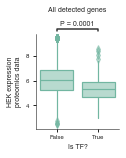

In [50]:
fig = plt.figure(figsize=(1.5, 1.75))

x_var = "is_tf"
y_var = "HEK_avrg"
ax = sns.boxplot(data=hek_prot, x=x_var, y=y_var,
                 color=sns.color_palette("Set2")[0])
mimic_r_boxplot(ax)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Is TF?")
ax.set_ylabel("HEK expression\nproteomics data")
ax.set_title("All detected genes\n\n")

x = hek_prot[hek_prot[x_var] == False][y_var].values
y = hek_prot[hek_prot[x_var] == True][y_var].values
pval = permutation_test(x, y, num_permutations=10000, seed=2023)
print(pval)
annotator = Annotator(ax=ax, pairs=[(False, True)], 
                      data=hek_prot, x=x_var, 
                      y=y_var, order=[False, True],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.4f}'.format(pval)])

fig.savefig("../../figures/fig5/HEK_proteomics_expr_TFs.pdf", dpi="figure", bbox_inches="tight")

In [51]:
pairs = pairs.merge(hek_prot[["gene_names_list", "HEK_avrg"]], left_on="gene_symbol",
                    right_on="gene_names_list", how="left")
pairs.sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,condensate_cat_merged,condensate_cat_detailed,max_gtex_ref,max_dev_ref,max_gtex_alt,max_dev_alt,max_gtex_gene,max_dev_gene,gene_names_list,HEK_avrg
41,THAP6,ENSG00000174796,THAP finger,False,THAP6|1/6|11H03,THAP6|4/6|05E05,ENST00000311638|ENST00000514480,ENST00000508105,False,False,...,No difference,BOTH -> CC,2.510815,3.080198,1.016590,1.389940,9.114698,10.815584,NaN,NaN
133,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|6/9|07H03,ENST00000354452|ENST00000629387,ENST00000457482,False,False,...,Difference,NC -> CC,0.081527,1.460023,0.816145,1.837599,4.996460,11.529060,TCF4,NaN
109,CTCF,ENSG00000102974,C2H2 ZF,False,CTCF|1/2|10F11,CTCF|2/2|01E10,ENST00000264010|ENST00000642819|ENST0000064475...,ENST00000401394,False,False,...,No difference,NC -> NC,3.158379,3.757004,2.210827,2.673683,5.369205,6.430687,CTCF,6.630122
75,FLI1,ENSG00000151702,Ets,False,FLI1|1/4|05A01,FLI1|3/4|05A02,ENST00000527786,ENST00000281428,False,False,...,No difference,CC -> CC,1.793262,0.976915,1.250916,1.432775,3.351349,3.557505,FLI1,5.032417
48,NFYA,ENSG00000001167,CBF/NF-Y,False,NFYA|1/3|07H01,NFYA|3/3|11D05,ENST00000341376,ENST00000353205,False,False,...,No difference,NC -> NC,2.597565,2.993471,2.334264,2.672370,5.620292,6.413893,NFYA,7.099454


5
21
0.8931106889311069
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: P = 0.8931


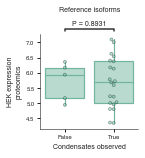

In [52]:
fig = plt.figure(figsize=(1.75, 1.75))

x_var = "condensates_observed_ref"
y_var = "HEK_avrg"
data = pairs[["clone_acc_ref", x_var, y_var]].drop_duplicates()
ax = sns.boxplot(data=data, x=x_var, y=y_var,
                 color=sns.color_palette("Set2")[0],
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=data, x=x_var, y=y_var, 
              edgecolor="black", linewidth=0.5, color=sns.color_palette("Set2")[0], ax=ax,
              size=3, alpha=0.5)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Condensates observed")
ax.set_ylabel("HEK expression\nproteomics")
ax.set_title("Reference isoforms\n\n")

x = data[data[x_var] == False][y_var].values
x = [x for x in x if not pd.isnull(x)]
print(len(x))
y = data[data[x_var] == True][y_var].values
y = [y for y in y if not pd.isnull(y)]
print(len(y))
pval = permutation_test(x, y, num_permutations=10000, seed=2023)
print(pval)
annotator = Annotator(ax=ax, pairs=[(False, True)], 
                      data=pairs, x=x_var, 
                      y=y_var, order=[False, True],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.4f}'.format(pval)])

fig.savefig("../../figures/fig5/HEK_proteomics_expr_cond.pdf", dpi="figure", bbox_inches="tight")

In [53]:
pairs.HEK_Condensate_ref.value_counts()

CC      63
NC      32
BOTH    20
Name: HEK_Condensate_ref, dtype: int64

In [54]:
pairs[pairs["HEK_Condensate_ref"] == "CC"][["gene_symbol", "clone_acc_ref",
                                            "clone_acc_alt", "condensates_observed_ref",
                                            "condensates_observed_alt", "HEK_Condensate_ref",
                                            "HEK_Condensate_alt", "condensate_cat"]].head(20)

,gene_symbol,clone_acc_ref,clone_acc_alt,condensates_observed_ref,condensates_observed_alt,HEK_Condensate_ref,HEK_Condensate_alt,condensate_cat
3,GRHL3,GRHL3|3/7|08G09,GRHL3|1/7|08E10,True,False,CC,NaN,LOC
4,GRHL3,GRHL3|3/7|08G09,GRHL3|2/7|08A10,True,False,CC,NaN,LOC
5,GRHL3,GRHL3|3/7|08G09,GRHL3|4/7|08F09,True,False,CC,NaN,LOC
6,GRHL3,GRHL3|3/7|08G09,GRHL3|6/7|08G10,True,True,CC,NC,Changed localization
7,GRHL3,GRHL3|3/7|08G09,GRHL3|7/7|08A11,True,True,CC,NC,Changed localization
12,RXRG,RXRG|1/2|11F12,RXRG|2/2|09F07,True,True,CC,CC,Unchanged
15,E2F6,E2F6|1/2|10C02,E2F6|2/2|01A04,True,True,CC,CC,Unchanged
16,ATF2,ATF2|1/6|12H04,ATF2|2/6|09E05,True,True,CC,CC,Unchanged
17,ATF2,ATF2|1/6|12H04,ATF2|2/6|09E05,True,True,CC,CC,Unchanged
18,ATF2,ATF2|1/6|12H04,ATF2|3/6|09C05,True,False,CC,NaN,LOC


In [55]:
hpa = pd.read_table("../../data/external/HPA_subcellular_location.tsv", sep="\t")
hpa["all_observed"] = hpa["Approved"].astype(str) + ";" + hpa["Enhanced"].astype(str) + ";" + hpa["Supported"].astype(str) + ";" + hpa["Uncertain"].astype(str)
hpa.head()

,Gene,Gene name,Reliability,Main location,Additional location,Extracellular location,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id,all_observed
0,ENSG00000000003,TSPAN6,Approved,Cell Junctions;Cytosol,Nucleoli fibrillar center,NaN,NaN,NaN,Cell Junctions;Cytosol;Nucleoli fibrillar center,NaN,Cytosol,NaN,NaN,Cell Junctions (GO:0030054);Cytosol (GO:000582...,Cell Junctions;Cytosol;Nucleoli fibrillar cent...
1,ENSG00000000457,SCYL3,Supported,Cytosol;Golgi apparatus,NaN,NaN,NaN,Cytosol;Golgi apparatus,NaN,NaN,NaN,NaN,NaN,Cytosol (GO:0005829);Golgi apparatus (GO:0005794),nan;nan;Cytosol;Golgi apparatus;nan
2,ENSG00000000460,C1orf112,Approved,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria (GO:0005739),Mitochondria;nan;nan;nan
3,ENSG00000000938,FGR,Approved,Plasma membrane,Aggresome,NaN,NaN,NaN,Aggresome;Plasma membrane,NaN,NaN,NaN,NaN,Aggresome (GO:0016235);Plasma membrane (GO:000...,Aggresome;Plasma membrane;nan;nan;nan
4,ENSG00000000971,CFH,Approved,Vesicles,NaN,Predicted to be secreted,NaN,NaN,Vesicles,NaN,NaN,NaN,NaN,Vesicles (GO:0043231),Vesicles;nan;nan;nan


In [56]:
def cytosolic_loc(row, col):
    cytosolic_locs_to_consider = ["Actin filaments", "Cleavage furrow", "Focal adhesion sites",
                                  "Intermediate filaments", "Centriolar satellite", "Centrosome",
                                  "Cytokinetic bridge", "Microtubule ends", "Microtubules",
                                  "Midbody", "Midbody ring", "Mitotic spindle",
                                  "Aggresome", "Cytoplasmic bodies", "Cytosol", "Rods & rings",
                                  "Mitochondria", "Endoplasmic reticulum", "Vesicles",
                                  "Endosomes", "Lipid droplets", "Lysosomes", "Peroxisomes",
                                  "Golgi apparatus", "Cell junctions", "Plasma membrane"]
    
    for loc in cytosolic_locs_to_consider:
        if loc in str(row[col]):
            return True
    return False

hpa["cyto_observed"] = hpa.apply(cytosolic_loc, col="all_observed", axis=1)
len(hpa[hpa["cyto_observed"] == True]["Gene name"].unique())

10043

In [57]:
hpa["cyto_observed_approved"] = hpa.apply(cytosolic_loc, col="Approved", axis=1)
len(hpa[hpa["cyto_observed_approved"] == True]["Gene name"].unique())

5872

In [58]:
pairs = pairs.merge(hpa, left_on="gene_symbol", right_on="Gene name", how="left")
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id,all_observed,cyto_observed,cyto_observed_approved
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,...,Nuclear speckles;Nucleoplasm,NaN,NaN,NaN,NaN,NaN,Nuclear speckles (GO:0016607);Nucleoplasm (GO:...,nan;nan;Nuclear speckles;Nucleoplasm;nan,False,False
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,...,Nucleoplasm,NaN,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),nan;nan;Nucleoplasm;nan,False,False
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,...,Nucleoplasm,NaN,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),nan;nan;Nucleoplasm;nan,False,False
3,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,...,NaN,Nucleoplasm,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),Nucleoplasm;nan;nan;nan,False,False
4,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,...,NaN,Nucleoplasm,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),Nucleoplasm;nan;nan;nan,False,False


In [59]:
dd = pairs[["gene_symbol", "clone_acc_ref",
            "condensates_observed_ref",
            "HEK_Condensate_ref",
            "Loc_Kaia_ref",
            "Approved",
            "cyto_observed_approved",
            "all_observed",
            "cyto_observed"]].drop_duplicates()

tot = dd.groupby("Loc_Kaia_ref")["clone_acc_ref"].agg("count").reset_index()
cyto = dd[dd["cyto_observed"] == True].groupby("Loc_Kaia_ref")["clone_acc_ref"].agg("count").reset_index()
cyto_perc = tot.merge(cyto, on="Loc_Kaia_ref")
cyto_perc.columns = ["Loc_Kaia_ref", "tot", "cyto_observed"]
cyto_perc["perc_cyto_observed"] = cyto_perc["cyto_observed"]/cyto_perc["tot"]*100


tot = dd[~pd.isnull(dd["Approved"])].groupby("Loc_Kaia_ref")["clone_acc_ref"].agg("count").reset_index()
cyto_app = dd[dd["cyto_observed_approved"] == True].groupby("Loc_Kaia_ref")["clone_acc_ref"].agg("count").reset_index()
cyto_perc_app = tot.merge(cyto_app, on="Loc_Kaia_ref")
cyto_perc_app.columns = ["Loc_Kaia_ref", "tot", "cyto_observed_approved"]
cyto_perc_app["perc_cyto_observed_approved"] = cyto_perc_app["cyto_observed_approved"]/cyto_perc_app["tot"]*100

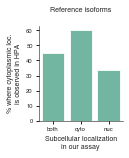

In [60]:
fig = plt.figure(figsize=(1.5, 1.75))

ax = sns.barplot(data=cyto_perc, x="Loc_Kaia_ref", y="perc_cyto_observed",
                 color=sns.color_palette("Set2")[0])

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Subcellular localization\nin our assay")
ax.set_ylabel("% where cytoplasmic loc.\nis observed in HPA")
ax.set_title("Reference isoforms\n")


fig.savefig("../../figures/fig5/hpa.pdf", dpi="figure", bbox_inches="tight")

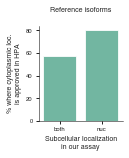

In [61]:
fig = plt.figure(figsize=(1.5, 1.75))

ax = sns.barplot(data=cyto_perc_app, x="Loc_Kaia_ref", y="perc_cyto_observed_approved",
                 color=sns.color_palette("Set2")[0])

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Subcellular localization\nin our assay")
ax.set_ylabel("% where cytoplasmic loc.\nis approved in HPA")
ax.set_title("Reference isoforms\n")


fig.savefig("../../figures/fig5/hpa_approved.pdf", dpi="figure", bbox_inches="tight")

In [62]:
cyto_perc

,Loc_Kaia_ref,tot,cyto_observed,perc_cyto_observed
0,both,31,14,45.161290
1,cyto,5,3,60.000000
2,nuc,18,6,33.333333


In [63]:
cyto_perc_app

,Loc_Kaia_ref,tot,cyto_observed_approved,perc_cyto_observed_approved
0,both,14,8,57.142857
1,nuc,5,4,80.000000


In [64]:
pairs[["clone_acc_ref", "cyto_observed"]].drop_duplicates().cyto_observed.value_counts()

False    33
True     26
Name: cyto_observed, dtype: int64

In [65]:
pairs[pairs["Loc_Kaia_ref"] == "cyto"][["gene_symbol", "clone_acc_ref",
                                            "condensates_observed_ref",
                                            "HEK_Condensate_ref",
                                            "all_observed",
                                            "cyto_observed"]].drop_duplicates().head(20)

,gene_symbol,clone_acc_ref,condensates_observed_ref,HEK_Condensate_ref,all_observed,cyto_observed
15,E2F6,E2F6|1/2|10C02,True,CC,nan;nan;Nucleoplasm;nan,False
68,HMBOX1,HMBOX1|2/5|03C07,True,CC,nan;nan;Cytosol;Nuclear bodies;Nucleoplasm;nan,True
87,GLI1,GLI1|1/3|10F09,True,CC,nan;nan;Cytosol;Nucleoplasm;nan,True
91,TBX5,TBX5|1/3|08E01,False,NaN,Nucleoplasm;nan;nan;nan,False
114,MLX,MLX|1/4|11G02,True,CC,Nuclear membrane;nan;Cytosol;Nucleoplasm;nan,True


In [66]:
dd[dd["HEK_Condensate_ref"] == "CC"][["gene_symbol", "clone_acc_ref",
                                            "condensates_observed_ref",
                                            "HEK_Condensate_ref",
                                            "all_observed",
                                            "cyto_observed"]].drop_duplicates().head(20)

,gene_symbol,clone_acc_ref,condensates_observed_ref,HEK_Condensate_ref,all_observed,cyto_observed
3,GRHL3,GRHL3|3/7|08G09,True,CC,Nucleoplasm;nan;nan;nan,False
12,RXRG,RXRG|1/2|11F12,True,CC,Nuclear bodies;Nucleoplasm;nan;nan;nan,False
15,E2F6,E2F6|1/2|10C02,True,CC,nan;nan;Nucleoplasm;nan,False
16,ATF2,ATF2|1/6|12H04,True,CC,nan;Nucleoplasm;nan;nan,False
26,KLF7,KLF7|1/8|01E06,True,CC,nan;nan;Nucleoplasm;Cytosol,True
32,PPARG,PPARG|1/4|10G02,True,CC,nan;Nucleoplasm;Vesicles;nan;nan,True
38,THRB,THRB|2/2|07E08,True,CC,nan;nan;Nuclear bodies;nan,False
43,EBF1,EBF1|1/3|12C07,True,CC,Nucleoplasm;Vesicles;nan;nan;nan,True
49,TFAP2A,TFAP2A|2/4|09G07,True,CC,nan;Nucleoplasm;nan;nan,False
55,CREB5,CREB5|1/3|08E11,True,CC,Nucleoplasm;Plasma membrane;Vesicles;nan;nan;nan,True


In [67]:
pairs["HEK_Condensate_ref_na"] = pairs["HEK_Condensate_ref"].fillna("none")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 27.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Reference isoforms\n\n')

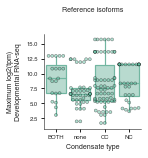

In [68]:
fig = plt.figure(figsize=(1.75, 1.75))

x_var = "HEK_Condensate_ref_na"
y_var = "max_dev_gene"
ax = sns.boxplot(data=pairs, x=x_var, y=y_var,
                 color=sns.color_palette("Set2")[0],
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=pairs, x=x_var, y=y_var, 
              edgecolor="black", linewidth=0.5, color=sns.color_palette("Set2")[0], ax=ax,
              size=3, alpha=0.5)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Condensate type")
ax.set_ylabel("Maximum log2(tpm)\nDevelopmental RNA-seq")
ax.set_title("Reference isoforms\n\n")

In [69]:
pairs[pairs["gene_symbol"] == "PPARG"][["clone_acc_ref", "clone_acc_alt", "HEK_Condensate_ref", 
                                        "HEK_Condensate_alt", "condensate_cat_detailed"]]

,clone_acc_ref,clone_acc_alt,HEK_Condensate_ref,HEK_Condensate_alt,condensate_cat_detailed
32,PPARG|1/4|10G02,PPARG|2/4|10F03,CC,NaN,CC -> None
33,PPARG|1/4|10G02,PPARG|3/4|01H02,CC,BOTH,CC -> BOTH
34,PPARG|1/4|10G02,PPARG|4/4|10H03,CC,NC,CC -> NC


In [70]:
pairs.columns

Index(['gene_symbol', 'Ensembl_gene_ID', 'family', 'is_dimerizing_TF_family',
       'clone_acc_ref', 'clone_acc_alt', 'Ensembl_transcript_IDs_ref',
       'Ensembl_transcript_IDs_alt', 'is_ref_novel_isoform',
       'is_alt_novel_isoform', 'is_MANE_select_isoform_cloned', 'n_aa_ref',
       'n_aa_alt', 'n_exons_ref', 'n_exons_alt', 'is_alternative_N_terminal',
       'is_alternative_C_terminal', 'is_alternative_internal_exon',
       'is_alternative_5_prime_donor', 'is_alternative_3_prime_acceptor',
       'is_exon_skipping', 'is_mutually_exclusive_exons',
       'is_intron_retention', 'dbd_insertion_n_aa', 'dbd_pct_lost',
       'dbd_affected', 'aa_seq_pct_id', 'n_positive_PPI_ref',
       'n_positive_PPI_alt', 'n_PPI_successfully_tested_in_ref_and_alt',
       'n_positive_PPI_ref_filtered', 'n_positive_PPI_alt_filtered',
       'n_shared_PPI', 'PPI_jaccard', 'dimer_ppi', 'other_than_dimer_ppi',
       'tf_tf_ppi', 'tf_cofactor_ppi', 'tf_signalling_ppi',
       'n_positive_PDI_ref', 

In [71]:
pairs[pairs["condensate_cat"] == "LOC"][["gene_symbol", "clone_acc_ref", "clone_acc_alt", "family",
                                         "PPI_jaccard", "PDI_jaccard", "activation_fold_change_log2",
                                         "condensate_cat_detailed"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,family,PPI_jaccard,PDI_jaccard,activation_fold_change_log2,condensate_cat_detailed
3,GRHL3,GRHL3|3/7|08G09,GRHL3|1/7|08E10,Grainyhead,NaN,NaN,-0.678207,CC -> None
4,GRHL3,GRHL3|3/7|08G09,GRHL3|2/7|08A10,Grainyhead,NaN,NaN,-0.187733,CC -> None
5,GRHL3,GRHL3|3/7|08G09,GRHL3|4/7|08F09,Grainyhead,0.500000,NaN,-0.395152,CC -> None
10,PBX1,PBX1|1/2|02A05,PBX1|2/2|02C05,Homeodomain,0.777778,NaN,-1.099522,BOTH -> None
18,ATF2,ATF2|1/6|12H04,ATF2|3/6|09C05,bZIP,0.666667,NaN,-0.706059,CC -> None
19,ATF2,ATF2|1/6|12H04,ATF2|3/6|09C05,bZIP,0.666667,NaN,-0.706059,CC -> None
22,ATF2,ATF2|1/6|12H04,ATF2|5/6|09A05,bZIP,0.333333,NaN,3.306912,CC -> None
23,ATF2,ATF2|1/6|12H04,ATF2|5/6|09A05,bZIP,0.333333,NaN,3.306912,CC -> None
32,PPARG,PPARG|1/4|10G02,PPARG|2/4|10F03,Nuclear receptor,0.833333,0.500000,-0.211298,CC -> None
55,CREB5,CREB5|1/3|08E11,CREB5|2/3|08A12,bZIP,0.333333,NaN,-2.342060,CC -> None
